Image Classification using Vision Transformer

In this assignment, I trained and evaluated the Vision Transformer on the Horses vs. Camels dataset.

The specific steps for this task are:
1. Prepare the dataset (choose any split).
2. Build the ViT model.
3. Train the model. Record how long it takes.
4. Evaluate the performance by reporting the confusion matrix.
5. Compared to the CNN that you evaluated on the same dataset in ICA02, explain which model performed better.
6. Explain how the Vision Transformer outperform state-of-the-art CNNs.

1) Prepare the dataset

Downlaod the dataset from https://www.kaggle.com/datasets/akrsnv/horses-and-camels, save to the same root repro with notebook.

In [55]:
# import libs
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import time
import sklearn
from sklearn.metrics import confusion_matrix
import itertools

Prepare the data

In [56]:
#prepare the data
local_file = os.path.abspath('./archive.zip')
path_to_zip = tf.keras.utils.get_file(local_file,'file://'+local_file)
PATH = os.path.join(os.path.dirname(path_to_zip), 'archive')
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

num_classes = 2
BATCH_SIZE = 32
input_shape = (32, 32,3)
#creat a train_dataset for training by using the keras.utils.image_dataset_from_directory utility.
train_dataset = keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=input_shape[:2])
#creat a test_dataset for testing by using the keras.utils.image_dataset_from_directory utility.
test_dataset = keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=input_shape[:2])

x_train, y_train = next(iter(train_dataset))
x_test, y_test = next(iter(test_dataset))

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

Found 360 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
x_train shape: (32, 32, 32, 3) - y_train shape: (32,)
x_test shape: (32, 32, 32, 3) - y_test shape: (32,)


2023-04-21 01:14:22.179260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [360]
	 [[{{node Placeholder/_4}}]]
2023-04-21 01:14:22.179682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [360]
	 [[{{node Placeholder/_0}}]]
2023-04-21 01:14:22.269933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [40]
	 [[

Configure the hyperparameters

In [57]:
# Configure the hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

Use data augmentation

In [58]:
data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        keras.layers.Resizing(image_size, image_size),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=0.02),
        keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


Implement multilayer perceptron (MLP)

In [59]:
#Implement multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x

Implement patch creation as a layer

In [60]:
#Implement patch creation as a layer
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


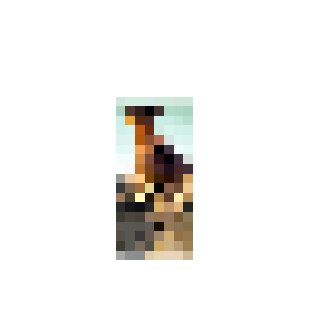

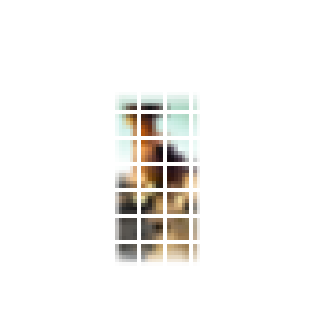

In [61]:
# display patches for a sample image
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.numpy().astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

Implement the patch encoding layer
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [62]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

2) Build the ViT model

The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

In [63]:
def create_vit_classifier():
    inputs = keras.layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = keras.layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

3) Train the model. Record how long it takes

In [67]:
#Compile, train, and evaluate the mode
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

# Start the timer
start_time = time.time()
print(f"the start time of training: {start_time:.2f}")

vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

# End the timer and print the time taken
end_time = time.time()
print(f"the end time of training: {end_time:.2f} ")
print(f"The training time taken: {end_time - start_time:.2f} seconds")

the start time of training: 1682057989.21
Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 2.4337 - accuracy: 0.3929 - val_loss: 5.3299 - val_accuracy: 0.2500
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 3.8575 - accuracy: 0.5357 - val_loss: 7.6543 - val_accuracy: 0.7500
Epoch 3/100
1/1 [==============================] - 1s 885ms/step - loss: 14.4962 - accuracy: 0.5714 - val_loss: 1.9567 - val_accuracy: 0.5000
Epoch 4/100
1/1 [==============================] - 1s 846ms/step - loss: 2.9426 - accuracy: 0.5714 - val_loss: 1.5915 - val_accuracy: 0.5000
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 1.2156 - accuracy: 0.7143 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 1s 893ms/step - loss: 2.4937 - accuracy: 0.6429 - val_loss: 8.0056 - val_accuracy: 0.2500
Epoch 7/100
1/1 [==============================] - 1s 914ms/step - loss: 4.7522 - accuracy: 0.5357 - val_loss: 8.0532e

4) Evaluate the performance by reporting the confusion matrix

1/1 [==============================] - 1s 807ms/step
[0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1]
[0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0]
[[14  4]
 [ 3 11]]


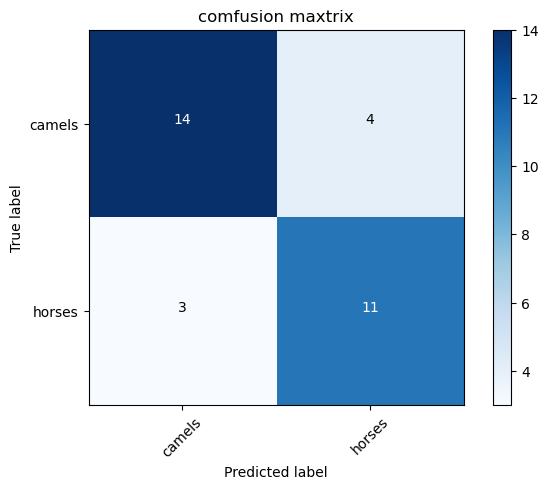

In [65]:
# Make predictions on test set
y_pred= vit_classifier.predict(x_test)
# Convert predicted values to binary
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)
# Convert y_true tensor to numpy array
y_true = y_test.numpy()
cm = confusion_matrix(y_true, y_pred,labels=[0,1])
print(y_true)
# Print confusion matrix
print(cm)

classes = ['camels','horses']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('comfusion maxtrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
    horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('./vit_confusion_matrix.jpg')

5) Compared to the CNN that you evaluated on the same dataset in ICA02, explain which model performed better.

The the model using weight fine-tuning in ICA02 performed better than ViT model on the same dataset. The reason may be due to the dataset only has 2 classes, and the dataset size is not big, only hundrends images. It suggests that the pre-trained weights used for fine-tuning were more appropriate for the this dataset, resulting in better performance. It's possible that the ViT model may perform better on other datasets or under different conditions.

6) Explain how the Vision Transformer outperform state-of-the-art CNNs

The Vision Transformer (ViT) has demonstrated state-of-the-art performance on several computer vision tasks, surpassing the performance of convolutional neural networks (CNNs), which have been the go-to architecture for image classification tasks for several years. Here are some reasons why ViT outperforms CNNs:

(1) Attention Mechanism: The key difference between ViT and CNNs is the use of the self-attention mechanism. ViT applies the Transformer's self-attention mechanism to images to extract features and create representations. The attention mechanism allows the model to focus on the most relevant parts of the image, enabling it to capture long-range dependencies and relationships between image elements, resulting in more accurate and robust representations.

(2) Better Scalability: CNNs rely on convolutional layers, which are designed to capture local features in images. As a result, they are limited in their ability to scale to larger image sizes, and more layers must be added to capture global features effectively. On the other hand, ViT can process the entire image at once, making it more scalable and easier to extend to larger image sizes.

(3) Fewer Parameters: Compared to CNNs, ViT requires fewer parameters, which makes it faster to train and more efficient to use. ViT replaces the convolutional layers with self-attention layers, reducing the number of parameters needed to represent the input. This efficiency is particularly important in applications where computational resources are limited.

(4) Pre-training: Pre-training with large amounts of unlabeled data is crucial for the performance of deep neural networks. ViT leverages the large-scale pre-training approach used in language modeling, where the model is first trained on a large corpus of text, and then fine-tuned on a downstream task such as image classification. This pre-training enables the model to learn useful and robust features from large amounts of data, improving its ability to generalize to new tasks and datasets.